### Decoy Effect

<span style="color:red">
To be decided:<br>



- How many runs per experiment? 50 is not a lot.<br> 
- Maybe set n globally and not in each run_decoy call<br>
<br>
- Huge deviations in runtime of cells: 50x5 function calls for GPT-3.5-Turbo can take ~5 min up to ~120 min (24.11.2023)<br>
<br>

</span>

"temperature - A measure of how often the model outputs a less likely token. The higher the temperature, the more random (and usually creative) the output. This, however, is not the same as “truthfulness”. For most factual use cases such as data extraction, and truthful Q&A, the temperature of 0 is best." (https://help.openai.com/en/articles/6654000-best-practices-for-prompt-engineering-with-openai-api)


As of right now (28.11.2023), querying each prompt 50 times for 5 temperature values over 8 prompts and the two openai 2 models, we issue **4000 API calls**. 


-------------------------------------

This notebook aims to recreate some findings concerning the **Decoy Effect** used in pricing. 

The answer options for this experiment are literal copies of the original study. Only the words "priced at __$" were added to each option. Furthermore, their wording remains the same
through the entire experiment, being: 
-  A: One-year subscription to Economist.com. Includes online access to all articles from The Economist since 1997, priced at 59$.
-  B: One-year subscription to the print edition of The Economist, priced at 125$.
-  C: One-year subscription to the print edition of The Economist and online access to all articles from The Economist since 1997, priced at 125$.


#### From Ariely's Book "Predictably irrational":

"When I gave these options to 100 students at MIT's Sloan
School of Management, they opted as follows:
1. Internet-only subscription for $59—16 students
2. Print-only subscription for $125—zero students
3. Print-and-Internet subscription for $ 125—84 students"

(page 5)

"And the absence of the decoy
had them choosing differently, with 32 for print-and-Internet
and 68 for Internet-only"

(page 6)

|Answer option          | Scenario 1 | Scenario 2 (no 2nd option)|
|-----------------------|--------------|-----------|
| Online subscription   |     16%      |  68%       |
| Print subscribtion    |      0%     | 0%        |
| Combination           |     84%   | 32%        |



In [65]:
from openai import OpenAI
import openai
import matplotlib.pyplot as plt
import os 
import numpy as np
import pandas as pd
from tqdm import tqdm

In [66]:
# Get API key (previously saved as environmental variable)
openai.api_key = os.environ["OPENAI_API_KEY"]

# Set client
client = OpenAI()

# Set global plot style 
plt.style.use('seaborn-v0_8')

# Set plots to be displayed in notebook
%matplotlib inline

-----------------------------------------------------------

#### Setting up the prompts used for the experiment

We now formulate 8 different prompts: 

First of all, we present the model with the original situation i.e. 3 answer options. To recreate the second scenario of the study, we tell the model that the second (decoy) option has now been removed. 
Furthermore we **prime** the model play the role of a marker researcher, who knows about the decoy effect, and query the model with both study situationbs again.

Afterwards, in order to research possible biases induced by either the answer letters themselves (A, B, C) or the order of the answers, we correct for this and prompt the model 4 times again.

- Prompt 1: Unprimed & all answer options

In [88]:
prompt_1 = """You are presented with the following subscription alternatives for the "The Economist" magazine:
        A: One-year subscription to Economist.com. Includes online access to all articles from The Economist since 1997, priced at 59$.
        B: One-year subscription to the print edition of The Economist, priced at 125$.
        C: One-year subscription to the print edition of The Economist and online access to all articles from The Economist since 1997, priced at 125$.
        Which alternative would you choose? Please answer by only giving the letter of the alternative you would choose without any reasoning."""

- Prompt 2: Unprimed & second option (decoy) removed

In [89]:
prompt_2 = """You are presented with the following subscription alternatives for the "The Economist" magazine:
        A: One-year subscription to Economist.com. Includes online access to all articles from The Economist since 1997, priced at 59$.
        B: One-year subscription to the print edition of The Economist and online access to all articles from The Economist since 1997, priced at 125$. 
        Which alternative would you choose? Please answer by only giving the letter of the alternative you would choose without any reasoning."""

# Removed original option B and made option C the new option B

- Prompt 3: Primed & all answer options

In [90]:
prompt_3 = """You are a market researcher that knows about the Decoy Effect in pricing. 
        You are presented with the following subscription alternatives for the "The Economist" magazine:
        A: One-year subscription to Economist.com. Includes online access to all articles from The Economist since 1997, priced at 59$.
        B: One-year subscription to the print edition of The Economist, priced at 125$.
        C: One-year subscription to the print edition of The Economist and online access to all articles from The Economist since 1997, priced at 125$.
        Which alternative would you choose? Please answer by only giving the letter of the alternative you would choose without any reasoning."""


- Prompt 4: Primed & second option (decoy) removed

In [70]:
prompt_4 = """You are a market researcher that knows about the Decoy Effect in pricing. 
         You are presented with the following subscription alternatives for the "The Economist" magazine:
         A: One-year subscription to Economist.com. Includes online access to all articles from The Economist since 1997, priced at 59$.
         B: One-year subscription to the print edition of The Economist and online access to all articles from The Economist since 1997, priced at 125$.
         Which alternative would you choose? Please answer by only giving the letter of the alternative you would choose without any reasoning."""

# Removed original option B and made option C the new option B

---------------------

#### Renaming and reordering answer options

Following the approach of Mendler-Dünner et al. (2023), we do not only reorder the answers but also label them with letters, that are less common in the English language.
- A (online) -> Y
- B (print) -> Q
- C (combination) -> X

Afterwards option 1 is put last. Sticking to our original question design, the order would now be: B, C, A.
- N (print)
- T (combination)
- W (online)

**-> Use decoy_function2() for these prompts!**

- Prompt 5: Unprimed & all answer options, renamed & reordered

In [71]:
prompt_5 = """You are presented with the following subscription alternatives for the "The Economist" magazine:
         Q: One-year subscription to the print edition of The Economist, priced at 125$.
         X: One-year subscription to the print edition of The Economist and online access to all articles from The Economist since 1997, priced at 125$.
         Y: One-year subscription to Economist.com. Includes online access to all articles from The Economist since 1997, priced at 59$. 
         Which alternative would you choose? Please answer by only giving the letter of the alternative you would choose without any reasoning."""


- Prompt 6: Unprimed & second option (decoy) removed, renamed & reordered

In [72]:
prompt_6 = """You are presented with the following subscription alternatives for the "The Economist" magazine:
         X: One-year subscription to the print edition of The Economist and online access to all articles from The Economist since 1997, priced at 125$.
         Y: One-year subscription to Economist.com. Includes online access to all articles from The Economist since 1997, priced at 59$. 
         Which alternative would you choose? Please answer by only giving the letter of the alternative you would choose without any reasoning."""

# Removed option Q

- Prompt 7: Primed & all answer options, renamed & reordered

In [73]:
prompt_7 = """You are a market researcher that knows about the Decoy Effect in pricing. 
         You are presented with the following subscription alternatives for the "The Economist" magazine:
         Q: One-year subscription to the print edition of The Economist, priced at 125$.
         X: One-year subscription to the print edition of The Economist and online access to all articles from The Economist since 1997, priced at 125$.
         Y: One-year subscription to Economist.com. Includes online access to all articles from The Economist since 1997, priced at 59$. 
         Which alternative would you choose? Please answer by only giving the letter of the alternative you would choose without any reasoning."""

- Prompt 8: Primed & second option (decoy) removed, renamed & reordered

In [74]:
prompt_8 = """You are a market researcher that knows about the Decoy Effect in pricing. 
         You are presented with the following subscription alternatives for the "The Economist" magazine:
         X: One-year subscription to the print edition of The Economist and online access to all articles from The Economist since 1997, priced at 125$.
         Y: One-year subscription to Economist.com. Includes online access to all articles from The Economist since 1997, priced at 59$. 
         Which alternative would you choose? Please answer by only giving the letter of the alternative you would choose without any reasoning."""

# Removed option Q

------------------------------------------

- Helpful dictionaries 

The experiments we will run in this notebook are very similar in study design, and for same cases, also similar in the results we expect. We therefore need to make sure, that we associate the results with the correct study design. That is why the following dictionaries are implemented to look up e.g. what model was used for an experiment.

They will also be used inside the functions that call the API multiple times and output some information about the experiment in order to identify it correctly. 

In [75]:
# Dictionary that returns the literal prompt for a given experiment id (used in function call). key: experiment_id, value: prompt
experiment_prompts_dict = {
    "1_1": prompt_1,
    "1_2": prompt_2,
    "1_3": prompt_3,
    "1_4": prompt_4,
    "1_5": prompt_5,
    "1_6": prompt_6,
    "1_7": prompt_7,
    "1_8": prompt_8,
    "2_1": prompt_1,
    "2_2": prompt_2,
    "2_3": prompt_3,
    "2_4": prompt_4,
    "2_5": prompt_5,
    "2_6": prompt_6,
    "2_7": prompt_7,
    "2_8": prompt_8,
}

# The following dictionary is only used for a check in the function calls.
# It returns the variable name of the prompt that was used in the experiment. key: experiment_id, value: prompt_name
prompt_ids_dict = {
    "1_1": "prompt_1",
    "1_2": "prompt_2",
    "1_3": "prompt_3",
    "1_4": "prompt_4",
    "1_5": "prompt_5",
    "1_6": "prompt_6",
    "1_7": "prompt_7",
    "1_8": "prompt_8",
    "2_1": "prompt_1",
    "2_2": "prompt_2",
    "2_3": "prompt_3",
    "2_4": "prompt_4",
    "2_5": "prompt_5",
    "2_6": "prompt_6",
    "2_7": "prompt_7",
    "2_8": "prompt_8",
}


# Dictionary to look up which model to use for a given experiment id (used in function call). key: experiment id, value: model name
model_dict = {
    "1_1": "gpt-3.5-turbo",
    "1_2": "gpt-3.5-turbo",
    "1_3": "gpt-3.5-turbo",
    "1_4": "gpt-3.5-turbo",
    "1_5": "gpt-3.5-turbo",
    "1_6": "gpt-3.5-turbo",
    "1_7": "gpt-3.5-turbo",
    "1_8": "gpt-3.5-turbo",
    "2_1": "gpt-4-1106-preview",
    "2_2": "gpt-4-1106-preview",
    "2_3": "gpt-4-1106-preview",
    "2_4": "gpt-4-1106-preview",
    "2_5": "gpt-4-1106-preview",
    "2_6": "gpt-4-1106-preview",
    "2_7": "gpt-4-1106-preview",
    "2_8": "gpt-4-1106-preview",
    }


# Dictionary to look up, what the study design of each experiment was. key: experiment id, value: experiment design 
experiment_dict = {
    "1_1": f"Experiment 1_1 contains all answer options, is unprimed and uses {model_dict['1_1']}.",
    "1_2": f"Experiment 1_2 has the decoy removed, is unprimed and uses {model_dict['1_2']}.",
    "1_3": f"Experiment 1_3 contains all answer options, is primed and uses {model_dict['1_3']}.",
    "1_4": f"Experiment 1_4 has the decoy removed, is primed and uses {model_dict['1_4']}.",
    "1_5": f"Experiment 1_5 contains all answer options renamed and reordered, is unprimed and uses {model_dict['1_5']}.",
    "1_6": f"Experiment 1_6 has the decoy removed, answer options renamed and reordered, is unprimed and uses {model_dict['1_6']}.",
    "1_7": f"Experiment 1_7 contains all answer options renamed and reordered, is primed and uses {model_dict['1_7']}.",
    "1_8": f"Experiment 1_8 has the decoy removed, answer options renamed and reordered, is primed and uses {model_dict['1_8']}.",
    "2_1": f"Experiment 2_1 contains all answer options, is unprimed and uses {model_dict['2_1']}.",
    "2_2": f"Experiment 2_2 has the decoy removed, is unprimed and uses {model_dict['2_2']}.",
    "2_3": f"Experiment 2_3 contains all answer options, is primed and uses {model_dict['2_3']}.",
    "2_4": f"Experiment 2_4 has the decoy removed, is primed and uses {model_dict['2_4']}.",
    "2_5": f"Experiment 2_5 contains all answer options renamed and reordered, is unprimed and uses {model_dict['2_5']}.",
    "2_6": f"Experiment 2_6 has the decoy removed, answer options renamed and reordered, is unprimed and uses {model_dict['2_6']}.",
    "2_7": f"Experiment 2_7 contains all answer options renamed and reordered, is primed and uses {model_dict['2_7']}.",
    "2_8": f"Experiment 2_8 has the decoy removed, answer options renamed and reordered, is primed and uses {model_dict['2_8']}.",
}

# Dictionary to look up the original results of the experiments. key: experiment id, value: original result
results_dict = {
    "1_1": "A: 16%, B: 0%, C: 84%",
    "1_2": "A: 68%, B: 0%, C: 32%",
    "1_3": "A: 16%, B: 0%, C: 84%",
    "1_4": "A: 68%, B: 0%, C: 32%",
    "1_5": "A: 16%, B: 0%, C: 84%",
    "1_6": "A: 68%, B: 0%, C: 32%",
    "1_7": "A: 16%, B: 0%, C: 84%",
    "1_8": "A: 68%, B: 0%, C: 32%",
    "2_1": "A: 16%, B: 0%, C: 84%",
    "2_2": "A: 68%, B: 0%, C: 32%",
    "2_3": "A: 16%, B: 0%, C: 84%",
    "2_4": "A: 68%, B: 0%, C: 32%",
    "2_5": "A: 16%, B: 0%, C: 84%",
    "2_6": "A: 68%, B: 0%, C: 32%",
    "2_7": "A: 16%, B: 0%, C: 84%",
    "2_8": "A: 68%, B: 0%, C: 32%",
}

----------------------------------------------

#### Functions 

The following functions are introduced in order to emulate a survey for our pre-implemented prompts.

In [91]:
# Function to count answers depending on prompt design which is reflected in the experiment id
def count_answers(answers: list, experiment_id: str):
    if experiment_id in ["1_1", "1_3","2_1", "2_3"]:
        A = answers.count("A")
        B = answers.count("B")
        C = answers.count("C")
    elif experiment_id in ["1_2", "1_4", "2_2", "2_4"]:
        A = answers.count("A")
        B = 0 # Option B was removed
        C = answers.count("B") # makes comparison of results over prompts easier 
    elif experiment_id in ["1_5", "1_7", "2_5", "2_7"]:
        A = answers.count("Y")
        B = answers.count("Q")
        C = answers.count("X")
    elif experiment_id in ["1_6", "1_8", "2_6", "2_8"]:
        A = answers.count("Y")
        B = 0 # Option Q was removed
        C = answers.count("X")
    return A, B, C

# Function to count correct answers depending on prompt design which is reflected in the experiment id (used for percentages)
def correct_answers(answers: list, experiment_id: str):
    if experiment_id in ["1_1", "1_3","2_1", "2_3"]:
        len_correct = sum(1 for ans in answers if ans in ["A", "B", "C"])
    elif experiment_id in ["1_2", "1_4", "2_2", "2_4"]:
        len_correct = sum(1 for ans in answers if ans in ["A", "B"])
    elif experiment_id in ["1_5", "1_7", "2_5", "2_7"]:
        len_correct = sum(1 for ans in answers if ans in ["Y", "Q", "X"])
    elif experiment_id in ["1_6", "1_8", "2_6", "2_8"]:
        len_correct = sum(1 for ans in answers if ans in ["Y", "X"])
    return len_correct  # to avoid division by zero

In [78]:
# Function to run a single experiment n times
def run_experiment(experiment_id: int, n: int,  progress_bar, temperature: int):
    """
    Function to query ChatGPT multiple times with a survey having answers designed as: A, B, C.
    
    Args:
        experiment_id (str): ID of the experiment to be run. Contains info about prompt and model
        n (int): Number of queries to be made
        temperature (int): Degree of randomness with range 0 (deterministic) to 2 (random)
        max_tokens (int): Maximum number of tokens in response object
        
    Returns:
        results (list): List containing count of answers for each option, also containing experiment_id, temperature and number of observations
        probs (list): List containing probability of each option being chosen, also containing experiment_id, temeperature and number of observations
    """
    answers = []
    for _ in range(n): 
        response = client.chat.completions.create(
            model = model_dict[experiment_id], 
            max_tokens = 5,
            temperature = temperature, # range is 0 to 2
            messages = [
            {"role": "system", "content": "Only answer with 1 letter."},
            {"role": "user", "content": experiment_prompts_dict[experiment_id]},
                   ])

        # Store the answer in the list
        answer = response.choices[0].message.content
        answers.append(answer.strip())
        # Update progress bar (given from either temperature loop, or set locally)
        progress_bar.update(1)

    # Count the answers
    A, B, C = count_answers(answers, experiment_id) # if/else statement of function deals with different answer options in different experiments
    
    # Count of correct answers
    len_correct = int(correct_answers(answers, experiment_id)) # if/else of function makes sure that we count the correct answers according to the experiment id 

    # Collecting results in a list
    results = [experiment_id, temperature, A, B, C, len_correct]

    # Calculate probabilities
    p_a = f"{(A / (len_correct + 0.000000001)) * 100:.2f}%"
    p_b = f"{(B / (len_correct + 0.000000001)) * 100:.2f}%"
    p_c = f"{(C / (len_correct + 0.000000001)) * 100:.2f}%"

    # Collect probabilities in a dataframe
    probs = [experiment_id, temperature, p_a, p_b, p_c, len_correct]
    # Print progress
    # print(f"Experiment {experiment_id} with {n} observations, using {prompt_ids_dict[experiment_id]} and temperature {temperature} completed.")

    return answers, results, probs 

In [92]:
# Function to run 1 experiment over different temperature values
def temperature_loop(experiment_id: str, temperature_list: list = [0, 0.5, 1, 1.5, 2], n: int = 50):
    """
    Function to run an experiment over different temperature values.
    
    Args:
        function (function): Function to be used for querying ChatGPT i.e. run_experiment()
        experiment_id (str): ID of th e experiment to be run. Contains info about prompt and model
        temperature_list (list): List of temperature values to be looped over
        n: Number of requests for each prompt per temperature value
        max_tokens: Maximum number of tokens in response object
        
    Returns:
        results_df: Dataframe with experiment results
        probs_df: Dataframe with answer probabilities
    """    
    # Empty lists for storing results
    results_list = []
    probs_list = []
    # Initialize progress bar -> used as input for run_experiment()
    progress_bar = tqdm(range(n*len(temperature_list)))

    # Loop over different temperature values, calling the input function n times each (i.e. queriyng ChatGPT n times)
    for temperature in temperature_list:
        answers, results, probs = run_experiment(experiment_id = experiment_id, n = n, temperature = temperature, progress_bar = progress_bar) 
        results_list.append(results)
        probs_list.append(probs)
    
    # Stop progress bar
    progress_bar.close()

    # Horizontally concatenate the results, transpose, and set index
    results_df = pd.DataFrame(results_list).transpose().set_index(pd.Index(["Experiment", "Temp", "p(A)", "p(B)", "p(C)", "Obs."]))
    probs_df = pd.DataFrame(probs_list).transpose().set_index(pd.Index(["Experiment", "Temp", "p(A)", "p(B)", "p(C)", "Obs."]))
   
    # Return some information about the experiment as a check
    check = f"{experiment_dict[experiment_id]} In this run, a total of {n*len(temperature_list)} requests were made using {prompt_ids_dict[experiment_id]}."
    # Print information about the experiment
    print(check)
    # Print original results 
    print(f"The original results were {results_dict[experiment_id]}.")

    
    return results_df, probs_df

In [87]:
# Function to plot distribution of answer probabilities
def plot_results(df: pd.DataFrame):
    
    # Get experiment id and model name for plot title from dictionaries
    experiment_id = df.iloc[0, 0]
    model = model_dict[experiment_id]
    
    X = df.loc["Temp"]
    p_a = df.loc["p(A)"].str.rstrip('%').astype('float')  # Convert percentages to float
    p_b = df.loc["p(B)"].str.rstrip('%').astype('float')
    p_c = df.loc["p(C)"].str.rstrip('%').astype('float')

    X_axis = np.arange(len(X)) 

    plt.figure(figsize = (10, 5))
    ax = plt.gca()
    ax.bar(X_axis- 0.25, p_a, 0.25, label = 'p(A)', color = "#8C1515") 
    ax.bar(X_axis, p_b, 0.25,  label = 'p(B)', color = "#507FAB") 
    ax.bar(X_axis+ 0.25 , p_c,  0.25, label = 'p(C)', color = '#D9A84A')

    ax.set_xticks(X_axis, X)
    ax.set_xlabel("Temperature")
    ax.set_ylabel("Probability (%)")
    ax.set_ylim(0, 110)
    ax.set_title(f"Distribution of answers per temperature value for experiment {experiment_id} using {model}")
    ax.legend()  
    plt.show()


---------------------

## Comparing different LLMs

The results variables will be structured as: results_model-id_prompt-id.

We will refer to "GPT-3.5-turbo" as model 1 and "GPT-4-1106-preview" as model 2.

#### Model 1: GPT-3.5-Turbo (Model training ended in September 2021)

- Simple test of repeated prompting function for fixed temperature

In [20]:
#results_test, probs_test = decoy_function(experiment_id = "2_2", n = 5, temperature = 1, max_tokens = 1)
#probs_test

# experiment_id, temp, p_a, p_b, p_c (in original survey), n_observations

- Simple test of function to loop over temperature values

In [96]:
# Call the function 
results_test_test, probs_test_test = temperature_loop(experiment_id = "2_2", temperature_list = [0, 0.5, 1, 1.5, 2], n = 5)

# Display probability dataframe
probs_test_test

,0,1,2,3,4
Experiment,2_2,2_2,2_2,2_2,2_2
Temp,0.0,0.5,1.0,1.5,2.0
p(A),100.00%,100.00%,100.00%,80.00%,60.00%
p(B),0.00%,0.00%,0.00%,0.00%,0.00%
p(C),0.00%,0.00%,0.00%,20.00%,40.00%
Obs.,5,5,5,5,5


- Prompt 1: Unprimed & all answer options

In [22]:
# Call function
results_1_1, probs_1_1 = temperature_loop(experiment_id = "1_1", temperature_list = [0, 0.5, 1, 1.5, 2], n = 50)
# Display results
probs_1_1

100%|██████████| 250/250 [32:43<00:00,  7.86s/it]   

Experiment 1_1 contains all answer options, is unprimed and uses gpt-3.5-turbo. In this run, a total of 250 requests were made using prompt_1.
The original results were A: 16%, B: 0%, C: 84%.


,0,1,2,3,4
Experiment,1_1,1_1,1_1,1_1,1_1
Temp,0.0,0.5,1.0,1.5,2.0
p(A),0.00%,0.00%,2.00%,4.00%,6.25%
p(B),0.00%,0.00%,0.00%,16.00%,14.58%
p(C),100.00%,100.00%,98.00%,80.00%,79.17%
Obs.,50,50,50,50,48


- Prompt 2: Unprimed & second option (decoy) removed

In [23]:
results_1_2, probs_1_2 = temperature_loop(experiment_id = "1_2", temperature_list = [0, 0.5, 1, 1.5, 2], n = 50)
probs_1_2

100%|██████████| 250/250 [15:03<00:00,  3.61s/it]   

Experiment 1_2 has the decoy removed, is unprimed and uses gpt-3.5-turbo. In this run, a total of 250 requests were made using prompt_2.
The original results were A: 68%, B: 0%, C: 32%.


,0,1,2,3,4
Experiment,1_2,1_2,1_2,1_2,1_2
Temp,0.0,0.5,1.0,1.5,2.0
p(A),0.00%,0.00%,2.00%,2.00%,4.26%
p(B),0.00%,0.00%,0.00%,0.00%,0.00%
p(C),100.00%,100.00%,98.00%,98.00%,95.74%
Obs.,50,50,50,50,47


- Prompt 3: Primed & all answer options

In [24]:
results_1_3, probs_1_3 = temperature_loop(experiment_id = "1_3", temperature_list = [0, 0.5, 1, 1.5, 2], n = 50)
probs_1_3

100%|██████████| 250/250 [03:22<00:00,  1.23it/s]

Experiment 1_3 contains all answer options, is primed and uses gpt-3.5-turbo. In this run, a total of 250 requests were made using prompt_3.
The original results were A: 16%, B: 0%, C: 84%.


,0,1,2,3,4
Experiment,1_3,1_3,1_3,1_3,1_3
Temp,0.0,0.5,1.0,1.5,2.0
p(A),0.00%,0.00%,0.00%,2.00%,2.22%
p(B),0.00%,0.00%,6.00%,6.00%,13.33%
p(C),100.00%,100.00%,94.00%,92.00%,84.44%
Obs.,50,50,50,50,45


- Prompt 4: Primed & second option (decoy) removed

In [85]:
results_1_4, probs_1_4 = temperature_loop(experiment_id = "1_4", temperature_list = [0, 0.5, 1, 1.5, 2], n = 50)
probs_1_4

,0,1,2,3,4
Experiment,1_4,1_4,1_4,1_4,1_4
Temp,0.0,0.5,1.0,1.5,2.0
p(A),0.00%,0.00%,0.00%,10.00%,10.42%
p(B),0.00%,0.00%,0.00%,0.00%,0.00%
p(C),100.00%,100.00%,100.00%,90.00%,89.58%
Obs.,50,50,50,50,48



-----------------------------

- Prompt 5: Unprimed & all answer options, renamed & reordered

In [26]:
results_1_5, probs_1_5 = temperature_loop(experiment_id = "1_5", temperature_list = [0, 0.5, 1, 1.5, 2], n = 50)
probs_1_5

100%|██████████| 250/250 [21:11<00:00,  5.08s/it]   

Experiment 1_5 contains all answer options renamed and reordered, is unprimed and uses gpt-3.5-turbo. In this run, a total of 250 requests were made using prompt_5.
The original results were A: 16%, B: 0%, C: 84%.


,0,1,2,3,4
Experiment,1_5,1_5,1_5,1_5,1_5
Temp,0.0,0.5,1.0,1.5,2.0
p(A),0.00%,0.00%,6.00%,20.00%,31.25%
p(B),0.00%,0.00%,0.00%,0.00%,2.08%
p(C),100.00%,100.00%,94.00%,80.00%,66.67%
Obs.,50,50,50,50,48


- Prompt 6: Unprimed & second option (decoy) removed, renamed & reordered

In [27]:
results_1_6, probs_1_6 = temperature_loop(experiment_id = "1_6", temperature_list = [0, 0.5, 1, 1.5, 2], n = 50)
probs_1_6

100%|██████████| 250/250 [03:31<00:00,  1.18it/s]

Experiment 1_6 has the decoy removed, answer options renamed and reordered, is unprimed and uses gpt-3.5-turbo. In this run, a total of 250 requests were made using prompt_6.
The original results were A: 68%, B: 0%, C: 32%.


,0,1,2,3,4
Experiment,1_6,1_6,1_6,1_6,1_6
Temp,0.0,0.5,1.0,1.5,2.0
p(A),100.00%,78.00%,78.00%,66.00%,64.58%
p(B),0.00%,0.00%,0.00%,0.00%,0.00%
p(C),0.00%,22.00%,22.00%,34.00%,35.42%
Obs.,50,50,50,50,48


- Prompt 7: Primed & all answer options, renamed & reordered

In [28]:
results_1_7, probs_1_7 = temperature_loop(experiment_id = "1_7", temperature_list = [0, 0.5, 1, 1.5, 2], n = 50)
probs_1_7

100%|██████████| 250/250 [03:00<00:00,  1.38it/s]

Experiment 1_7 contains all answer options renamed and reordered, is primed and uses gpt-3.5-turbo. In this run, a total of 250 requests were made using prompt_7.
The original results were A: 16%, B: 0%, C: 84%.


,0,1,2,3,4
Experiment,1_7,1_7,1_7,1_7,1_7
Temp,0.0,0.5,1.0,1.5,2.0
p(A),0.00%,2.00%,18.00%,28.57%,25.00%
p(B),0.00%,0.00%,0.00%,0.00%,0.00%
p(C),100.00%,98.00%,82.00%,71.43%,75.00%
Obs.,50,50,50,49,48


- Prompt 8: Primed & second option (decoy) removed, renamed & reordered

In [29]:
results_1_8, probs_1_8 = temperature_loop(experiment_id = "1_8", temperature_list = [0, 0.5, 1, 1.5, 2], n = 50)
probs_1_8

100%|██████████| 250/250 [06:51<00:00,  1.65s/it]

Experiment 1_8 has the decoy removed, answer options renamed and reordered, is primed and uses gpt-3.5-turbo. In this run, a total of 250 requests were made using prompt_8.
The original results were A: 68%, B: 0%, C: 32%.


,0,1,2,3,4
Experiment,1_8,1_8,1_8,1_8,1_8
Temp,0.0,0.5,1.0,1.5,2.0
p(A),0.00%,34.00%,36.00%,46.00%,36.17%
p(B),0.00%,0.00%,0.00%,0.00%,0.00%
p(C),100.00%,66.00%,64.00%,54.00%,63.83%
Obs.,50,50,50,50,47


-------------------------------------

#### Model 2: GPT-4-1106-preview (Model training ended in April 2023)

- Prompt 1: Unprimed & all answer options

In [125]:
#results_2_1, probs_2_1 = temperature_loop(experiment_id = "2_1", temperature_list = [0, 0.5, 1, 1.5, 2], n = 50)
probs_2_1

,0,1,2,3,4
Experiment,2_1,2_1,2_1,2_1,2_1
Temp,0.0,0.5,1.0,1.5,2.0
p(A),0.00%,0.00%,0.00%,2.00%,4.44%
p(B),0.00%,0.00%,0.00%,0.00%,0.00%
p(C),100.00%,100.00%,100.00%,98.00%,95.56%
Obs.,50,50,50,50,45


- Prompt 2: Unprimed & second option (decoy) removed

In [126]:
#results_2_2, probs_2_2 = temperature_loop(experiment_id = "2_2", temperature_list = [0, 0.5, 1, 1.5, 2], n = 50)
probs_2_2

,0,1,2,3,4
Experiment,2_2,2_2,2_2,2_2,2_2
Temp,0.0,0.5,1.0,1.5,2.0
p(A),100.00%,100.00%,94.00%,74.00%,66.67%
p(B),0.00%,0.00%,0.00%,0.00%,0.00%
p(C),0.00%,0.00%,6.00%,26.00%,33.33%
Obs.,50,50,50,50,45


- Prompt 3: Primed & all answer options

In [127]:
#results_2_3, probs_2_3 = temperature_loop(experiment_id = "2_3", temperature_list = [0, 0.5, 1, 1.5, 2], n = 50)
probs_2_3

,0,1,2,3,4
Experiment,2_3,2_3,2_3,2_3,2_3
Temp,0.0,0.5,1.0,1.5,2.0
p(A),0.00%,0.00%,0.00%,0.00%,0.00%
p(B),0.00%,0.00%,0.00%,0.00%,0.00%
p(C),100.00%,100.00%,100.00%,100.00%,100.00%
Obs.,50,50,50,50,49


- Prompt 4: Primed & second option (decoy) removed

In [128]:
#results_2_4, probs_2_4 = temperature_loop(experiment_id = "2_4", temperature_list = [0, 0.5, 1, 1.5, 2], n = 50)
probs_2_4

,0,1,2,3,4
Experiment,2_4,2_4,2_4,2_4,2_4
Temp,0.0,0.5,1.0,1.5,2.0
p(A),100.00%,98.00%,76.00%,68.00%,60.00%
p(B),0.00%,0.00%,0.00%,0.00%,0.00%
p(C),0.00%,2.00%,24.00%,32.00%,40.00%
Obs.,50,50,50,50,40


-----------------------------------------

- Prompt 5: Unprimed & all answer options, renamed & reordered

In [129]:
#results_2_5, probs_2_5 = temperature_loop(experiment_id = "2_5", temperature_list = [0, 0.5, 1, 1.5, 2], n = 50)
probs_2_5

,0,1,2,3,4
Experiment,2_5,2_5,2_5,2_5,2_5
Temp,0.0,0.5,1.0,1.5,2.0
p(A),0.00%,0.00%,0.00%,0.00%,0.00%
p(B),0.00%,0.00%,0.00%,0.00%,0.00%
p(C),100.00%,100.00%,100.00%,100.00%,100.00%
Obs.,50,50,50,49,47


- Prompt 6: Unprimed & second option (decoy) removed, renamed & reordered

In [124]:
#results_2_6, probs_2_6 = temperature_loop(experiment_id = "2_6", temperature_list = [0, 0.5, 1, 1.5, 2], n = 50)
probs_2_6

,0,1,2,3,4
Experiment,2_6,2_6,2_6,2_6,2_6
Temp,0.0,0.5,1.0,1.5,2.0
p(A),0.00%,8.00%,12.00%,32.65%,41.86%
p(B),0.00%,0.00%,0.00%,0.00%,0.00%
p(C),100.00%,92.00%,88.00%,67.35%,58.14%
Obs.,50,50,50,49,43


- Prompt 7: Primed & all answer options, renamed & reordered

In [123]:
#results_2_7, probs_2_7 = temperature_loop(experiment_id = "2_7", temperature_list = [0, 0.5, 1, 1.5, 2], n = 50)
probs_2_7

,0,1,2,3,4
Experiment,2_7,2_7,2_7,2_7,2_7
Temp,0.0,0.5,1.0,1.5,2.0
p(A),0.00%,0.00%,0.00%,0.00%,0.00%
p(B),0.00%,0.00%,0.00%,0.00%,2.08%
p(C),100.00%,100.00%,100.00%,100.00%,97.92%
Obs.,50,50,50,50,48


- Prompt 8: Primed & second option (decoy) removed, renamed & reordered

In [122]:
#results_2_8, probs_2_8 = temperature_loop(experiment_id = "2_8", temperature_list = [0, 0.5, 1, 1.5, 2], n = 50)
probs_2_8

,0,1,2,3,4
Experiment,2_8,2_8,2_8,2_8,2_8
Temp,0.0,0.5,1.0,1.5,2.0
p(A),0.00%,0.00%,2.00%,2.00%,11.90%
p(B),0.00%,0.00%,0.00%,0.00%,0.00%
p(C),100.00%,100.00%,98.00%,98.00%,88.10%
Obs.,50,50,50,50,42


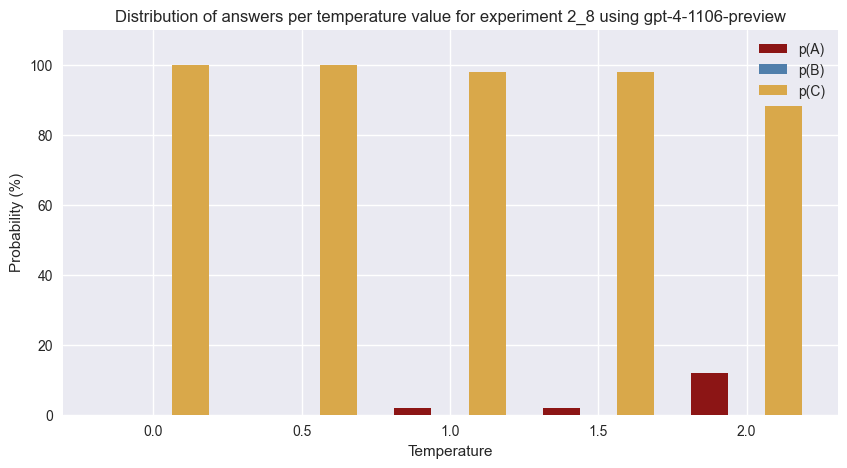

In [111]:
plot_results(probs_2_8)

In [ ]:
# Check if priming actually works
#answer = []
#response = client.chat.completions.create(
#        model = "gpt-3.5-turbo",
#        max_tokens = 100,
#        temperature = 1, # range is 0 to 2
#        messages = [
#        {"role": "user", "content": """Do you know about the Decoy Effect?"""},
#                   ])
## Store the answer in the list
#answer = response.choices[0].message.content

#answer

-----------------------------------------------------

- Save the results

In [121]:
# Set folder name to save results to
folder_name = "Output/DE_probs_dfs"

# Check if path already exists, only create folder if not 
if not os.path.exists(folder_name):
    os.mkdir(folder_name)
    print(f"Folder {folder_name} successfully created.")
else:
    print(f"Folder {folder_name} already exists in current directory.")

# Save dataframes with their respective experiment id as file name
for i in np.arange(1,3):
    for j in np.arange(1,9):
        exec(f"probs_{i}_{j}.to_csv('{folder_name}\DE_probs_{i}_{j}.csv')")

Folder DE_probs_dfs already exists in current directory.
